In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import seaborn as sns
import numpy.testing as npt
import unittest

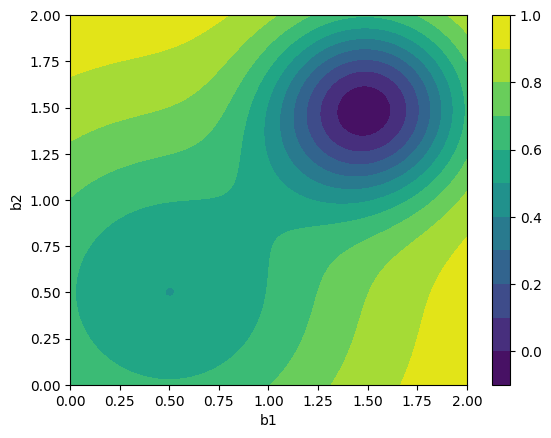

In [180]:
#Define data
N = 100
b1 = np.linspace(0,2,N)
b2 = np.linspace(0,2,N)
Nb1 = np.size(b1)
Nb2 = np.size(b2)

b01 = 0.5
b02 = 1.5

amp1 = 0.5
amp2 = 1

J = np.zeros([Nb1,Nb2])
for i in range(Nb1):
    for j in range(Nb2):
        J[i,j] = 1-amp1*np.exp(-(b1[i]-b01)**2-(b2[j]-b01)**2)-amp2*np.exp(-4*((b1[i]-b02)**2)-4*((b2[j]-b02)**2))

#plt all data
b1grid, b2grid = np.meshgrid(b1,b2)

#contour
plt.contourf(b1grid, b2grid, J,levels=10)
plt.xlabel('b1')
plt.ylabel('b2')
plt.colorbar()
plt.show()

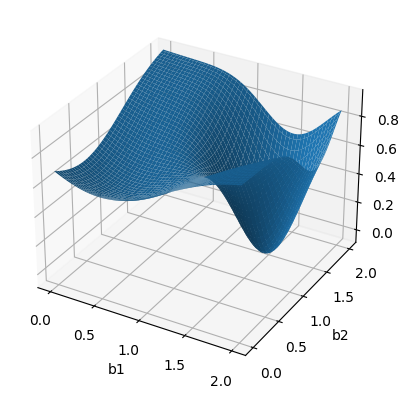

In [181]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(b1grid, b2grid, J)
plt.xlabel('b1')
plt.ylabel('b2')
plt.show()

In [182]:
Jmin = np.min(J)
Jmin

-0.06967594393296439

In [183]:
bt1 = np.random.uniform(0,2)
bt2 = np.random.uniform(0,2)

In [184]:
def generate_simplex(x0, step=0.1):
    """
    Create a simplex based at x0
    """
    yield x0.copy()
    for i,_ in enumerate(x0):
        x = x0.copy()
        x[i] += step
        yield x

def make_simplex(x0, step=0.1):
    return np.array(list(generate_simplex(x0, step)))

def centroid(points):
    """
    Compute the centroid of a list points given as an array.
    """
    return np.mean(points, axis=0)



class DownhillSimplex(object):

    refl = 1.
    ext = 1.
    cont = 0.5
    red = 0.5

    # max_stagnations: break after max_stagnations iterations with an improvement lower than no_improv_thr
    no_improve_thr=10e-6
    max_stagnations=10

    max_iter=100
    
    def __init__(self, f, points):
        '''
            f: (function): function to optimize, must return a scalar score 
                and operate over a numpy array of the same dimensions as x_start
            points: (numpy array): initial position
        '''
        self.f = f
        self.points = points

    def step(self, res):
        # centroid of the lowest face
        pts = np.array([tup[0] for tup in res[:-1]])
        x0 = centroid(pts)

        new_res = self.reflection(res, x0, self.refl)
        if new_res is not None:
            exp_res = self.expansion(new_res, x0, self.ext)
            if exp_res is not None:
                new_res = exp_res
        else:
            new_res = self.contraction(res, x0, self.cont)
            if new_res is None:
                new_res = self.reduction(res, self.red)
        return new_res

    def run(self):
        # initialize
        self.prev_best = self.f(self.points[0])
        self.stagnations = 0
        res = self.make_score(self.points)

        # simplex iter
        for iters in range(self.max_iter):
            res = self.sort(res)
            best = res[0][1]

            # break after max_stagnations iterations with no improvement
            if best < self.prev_best - self.no_improve_thr:
                self.stagnations = 0
                self.prev_best = best
            else:
                self.stagnations += 1
        
            if self.stagnations >= self.max_stagnations:
                return res[0]

            # Downhill-Simplex algorithm
            new_res = self.step(res)

            res = new_res
          
        else:
            raise Exception("No convergence after {} iterations".format(iters))


    def sort(self, res):
        """
        Order the points according to their value.
        """
        return sorted(res, key = lambda x: x[1])

    def reflection(self, res, x0, refl):
        """
        Reflection-extension step.
        refl: refl = 1 is a standard reflection
        """
        # reflected point and score
        xr = x0 + refl*(x0 - res[-1][0])
        rscore = self.f(xr)

        new_res = res[:]

        progress = rscore < new_res[-2][1]
        if progress: # if this is a progress, we keep it
            new_res[-1] = (xr, rscore)
            return new_res
        return None

    def expansion(self, res, x0, ext):
        """
        ext: the amount of the expansion; ext=0 means no expansion
        """
        xr, rscore = res[-1]
        # if it is the new best point, we try to expand
        if rscore < res[0][1]:
            xe = xr + ext*(xr - x0)
            escore = self.f(xe)
            if escore < rscore:
                new_res = res[:]
                new_res[-1] = (xe, escore)
                return new_res
        return None

    def contraction(self, res, x0, cont):
        """
        cont: contraction parameter: should be between zero and one
        """
        xc = x0 + cont*(res[-1][0] - x0)
        cscore = self.f(xc)

        new_res = res[:]

        progress = cscore < new_res[-1][1]
        if progress:
            new_res[-1] = (xc, cscore)
            return new_res
        return None

    def reduction(self, res, red):
        """
        red: reduction parameter: should be between zero and one
        """
        pts = np.array([pts for (pts,_) in res])
        dirs = pts - pts[0]
        reduced_points = pts[0] + red*dirs
        new_res = self.make_score(reduced_points)
        return new_res

    def make_score(self, points):
        res = [(pt, self.f(pt)) for pt in points]
        return res

    def run1(self):
        # initialize
        self.prev_best = self.f(self.points[0])
        self.stagnations = 0
        res = self.make_score(self.points)
        his = []
        # simplex iter
        for iters in range(self.max_iter):
            res = self.sort(res)
            best = res[0][1]

            # break after max_stagnations iterations with no improvement
            if best < self.prev_best - self.no_improve_thr:
                self.stagnations = 0
                self.prev_best = best
            else:
                self.stagnations += 1
        
            # if self.stagnations >= self.max_stagnations:
            #     return res[0]

            # Downhill-Simplex algorithm
            new_res = self.step(res)
            res = new_res
            # for i in range(len(res)):
            #     plt.scatter(res[i][0],res[i][1])
            # plt.show()
            his.append(res)
        return his

In [185]:
def f(x):
    return 1-amp1*np.exp(-(x[0]-b01)**2-(x[1]-b01)**2)-amp2*np.exp(-4*((x[0]-b02)**2)-4*((x[1]-b02)**2))

def generate_simplex0():
    bt1 = np.random.uniform(0,2)
    bt2 = np.random.uniform(0,2)
    return [np.array([bt1,bt2]),np.array([bt1+0.1,bt2]),np.array([bt1,bt2+0.1]),np.array([bt1-0.1,bt2]),np.array([bt1,bt2-0.1])]

In [186]:
l = generate_simplex0()

In [187]:
N = DownhillSimplex(f, l)
res = N.run()
bf = res[0]

In [188]:
bf

array([1.48166408, 1.48224514])

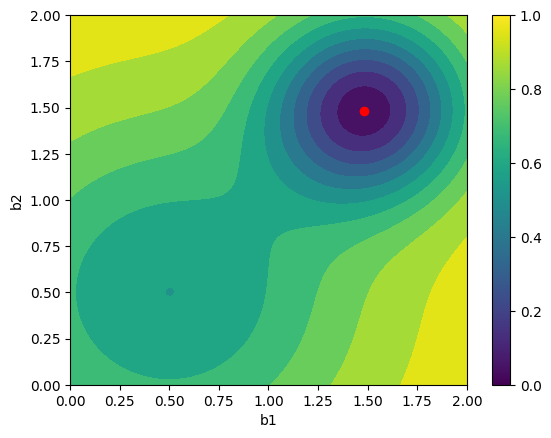

In [189]:
#contour
plt.contourf(b1grid, b2grid, J,levels=10)
plt.scatter(bf[0],bf[1],color = 'r')
plt.xlabel('b1')
plt.ylabel('b2')
plt.colorbar()
plt.show()

In [190]:
his = N.run1()

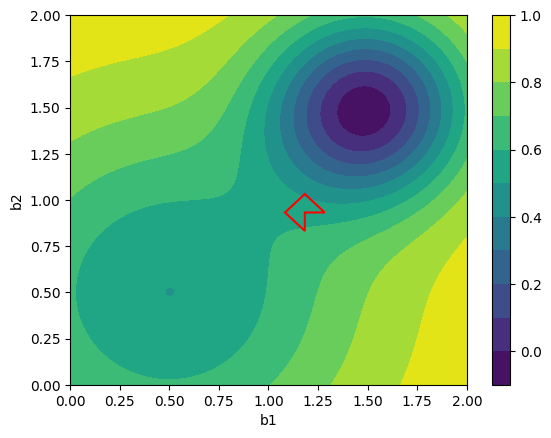

In [191]:
plt.contourf(b1grid, b2grid, J,levels=10)
# for j in range(len(l)):
#     plt.scatter(l[j][0],l[j][1],color = 'r')
poly = plt.Polygon(l, facecolor="none", edgecolor="r",
                       linewidth=1.5)
plt.gca().add_patch(poly)
plt.xlabel('b1')
plt.ylabel('b2')
plt.colorbar()
plt.savefig('fig6/test0.png')
plt.show()

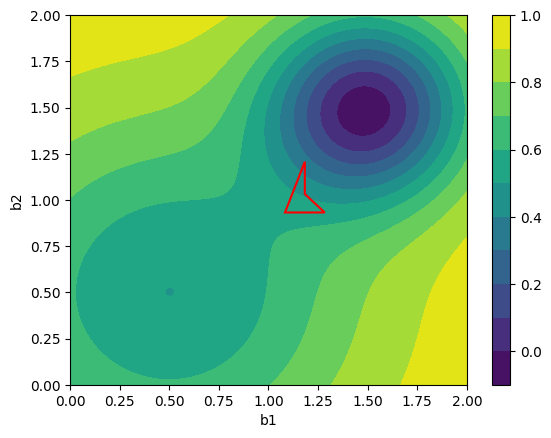

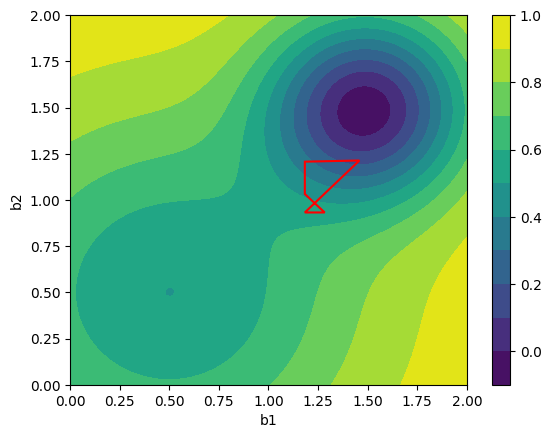

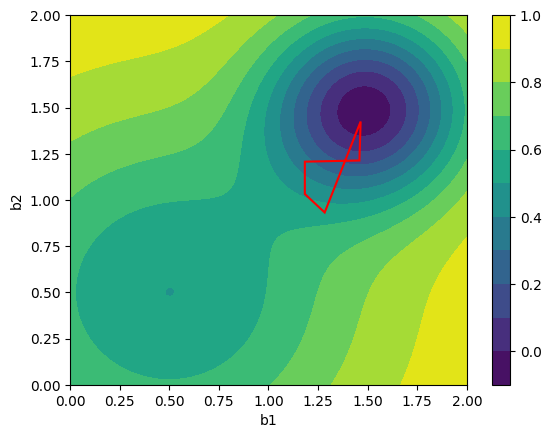

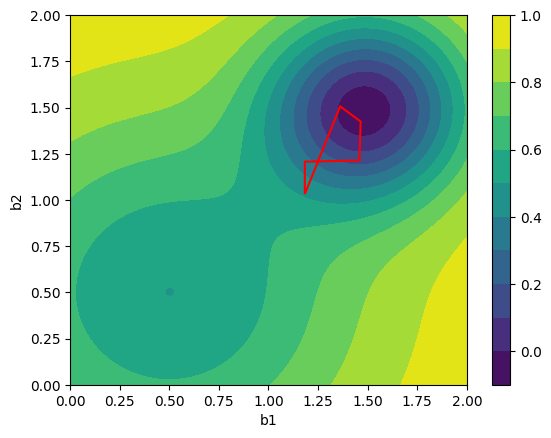

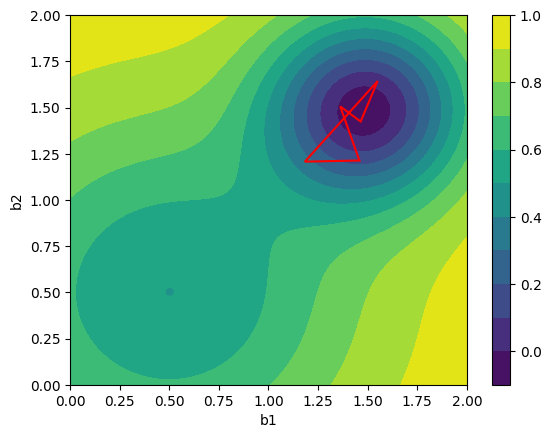

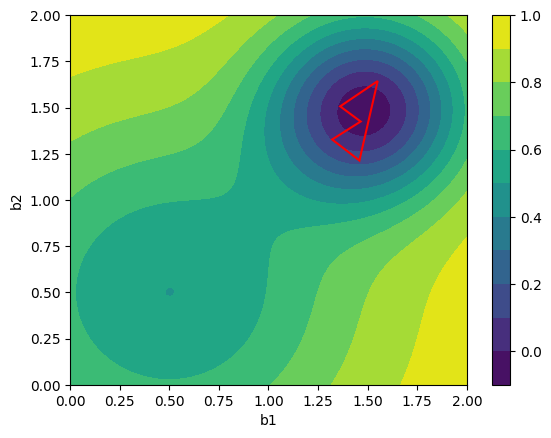

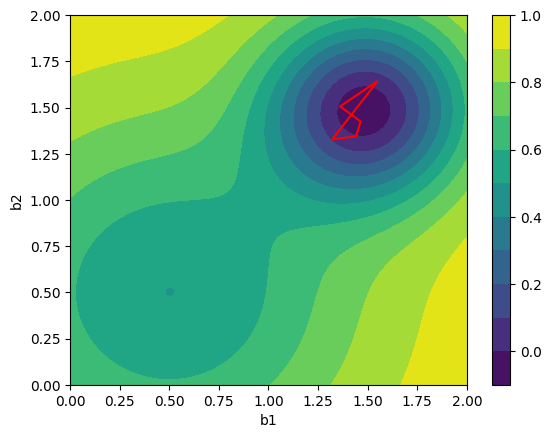

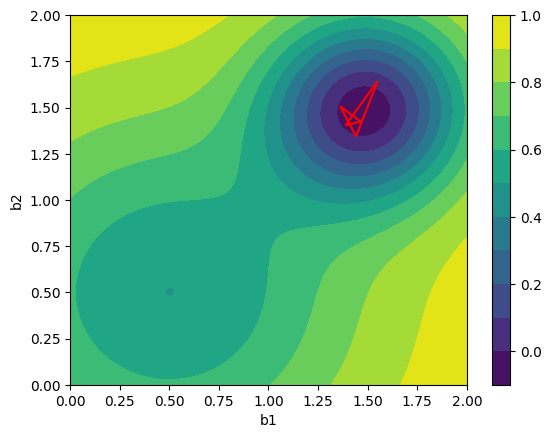

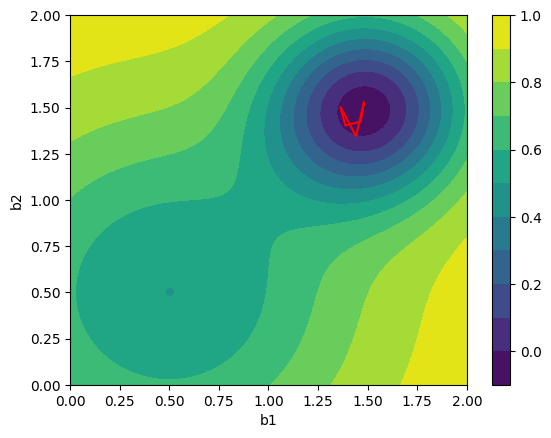

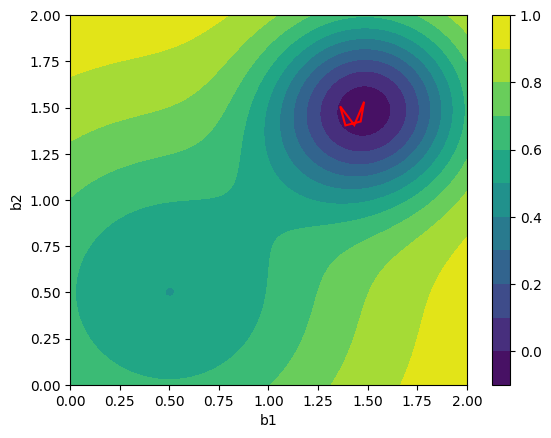

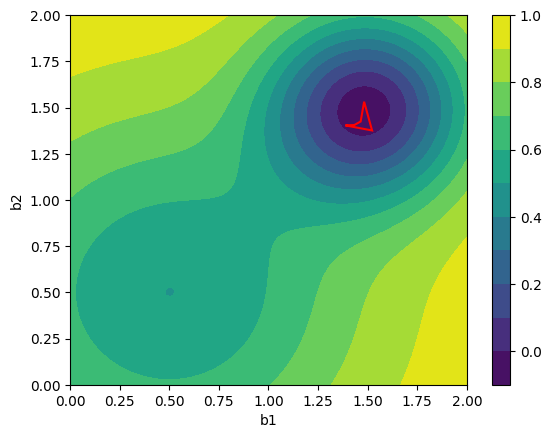

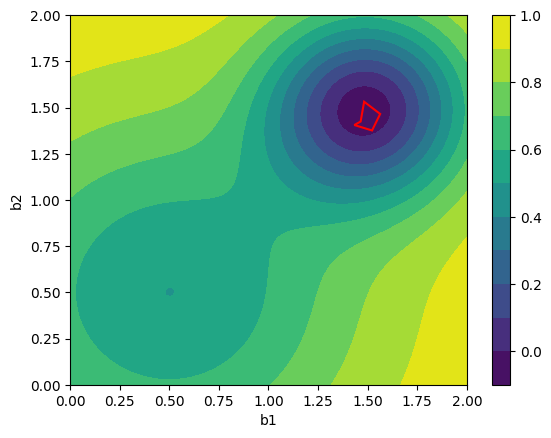

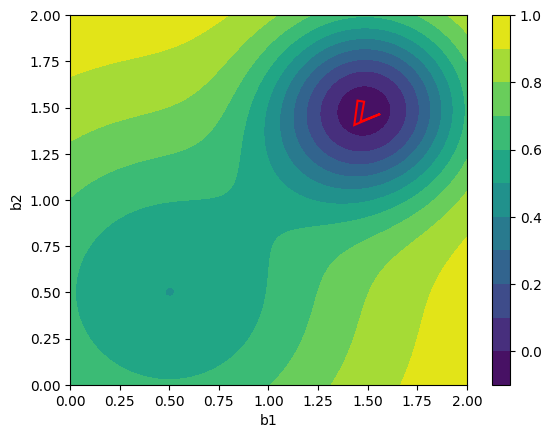

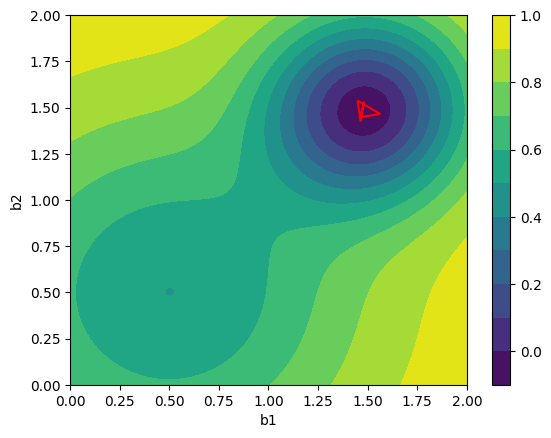

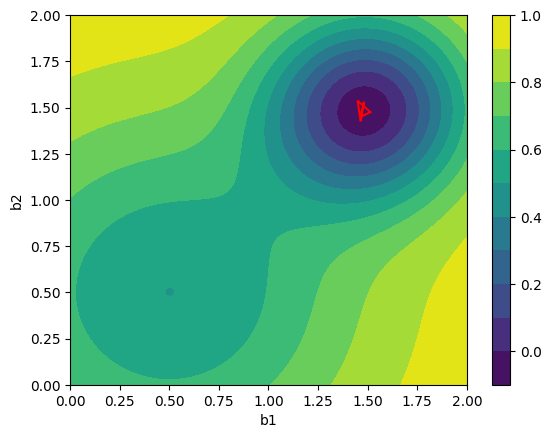

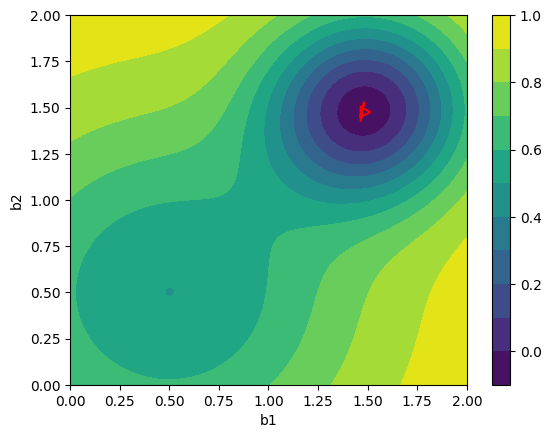

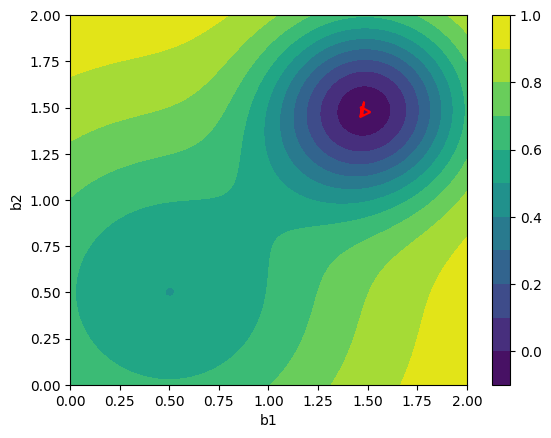

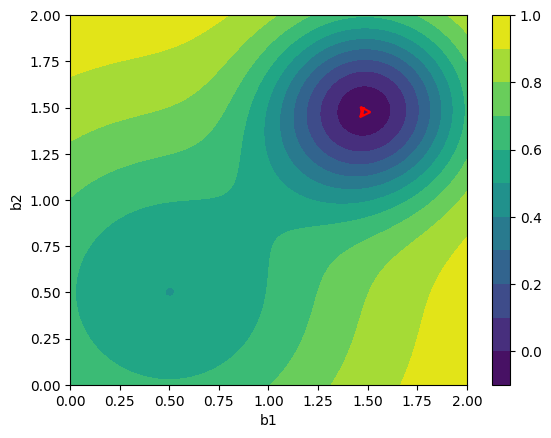

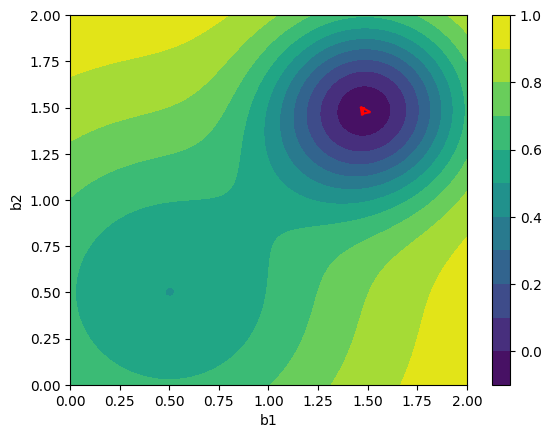

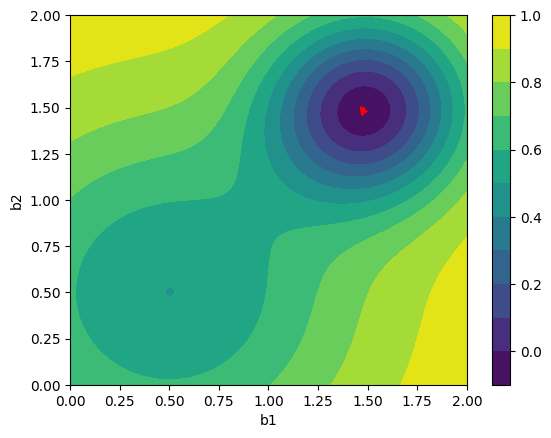

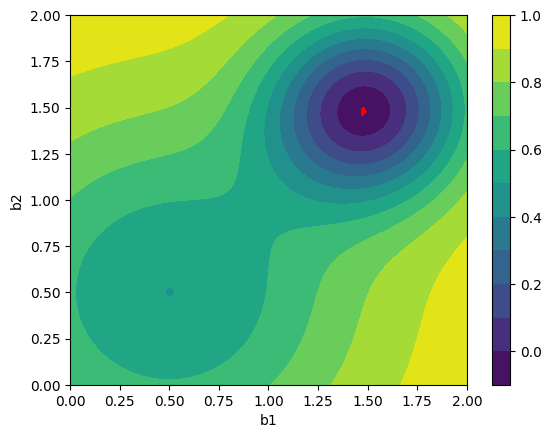

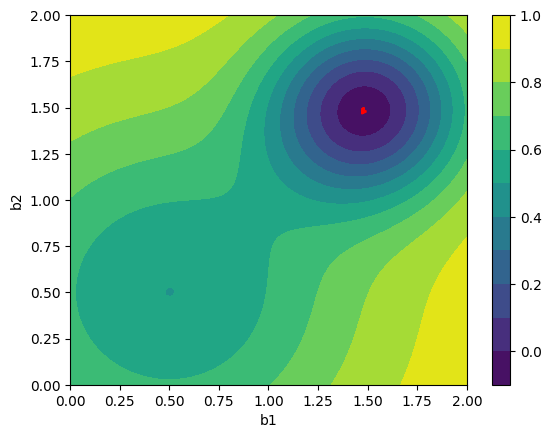

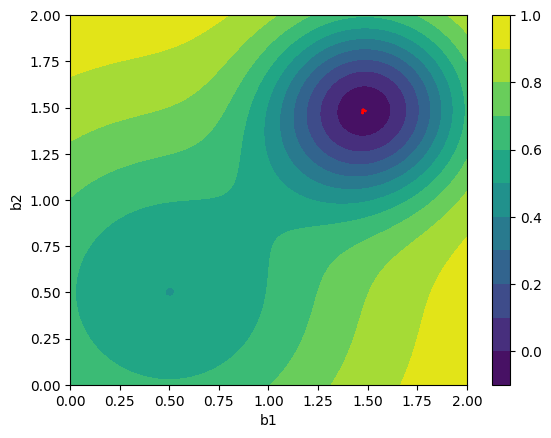

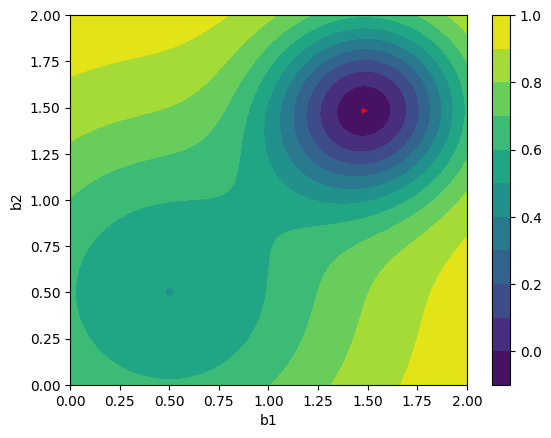

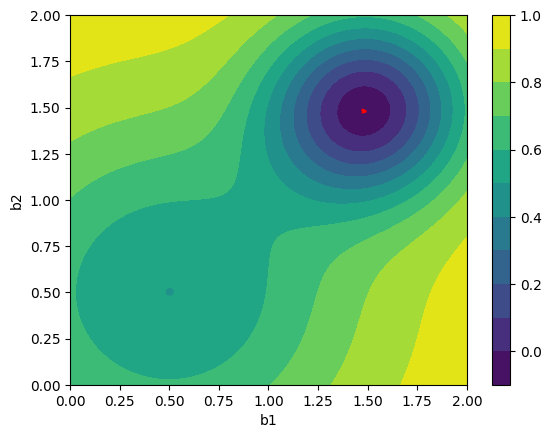

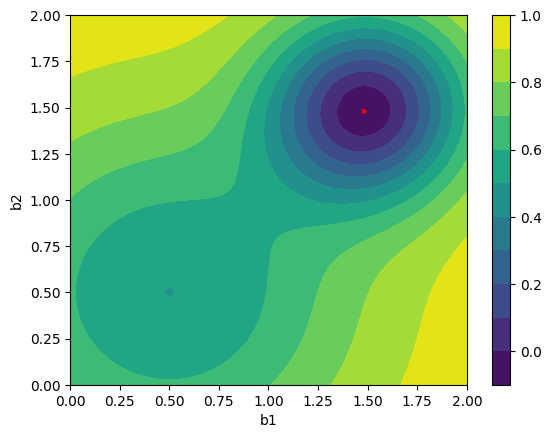

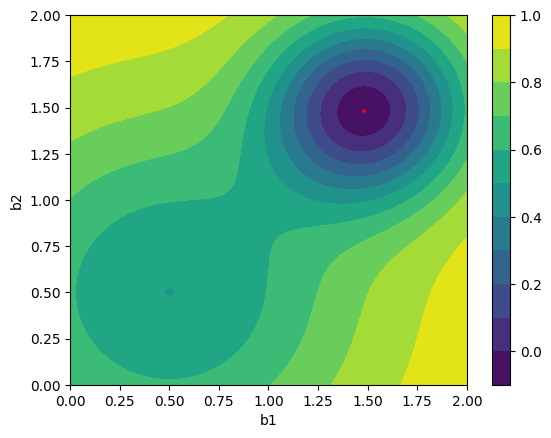

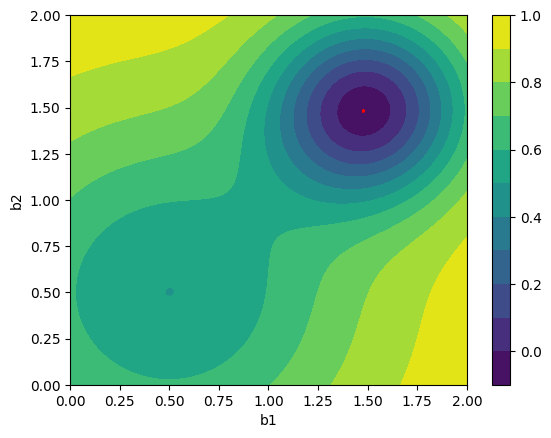

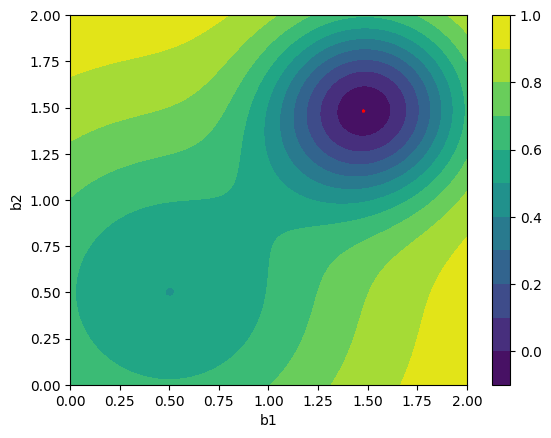

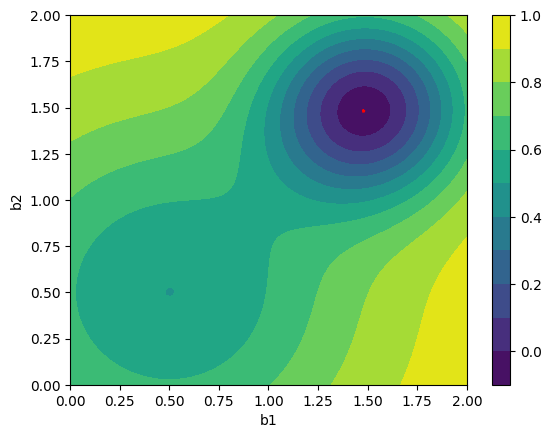

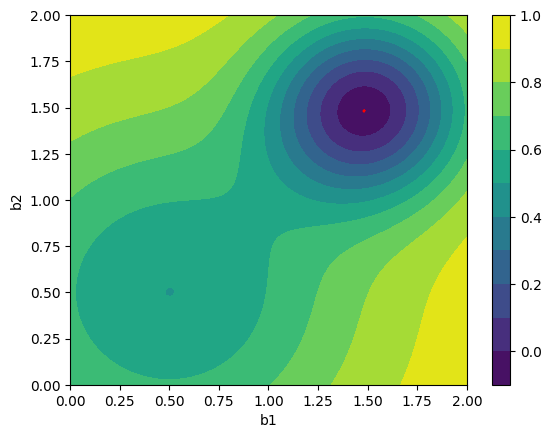

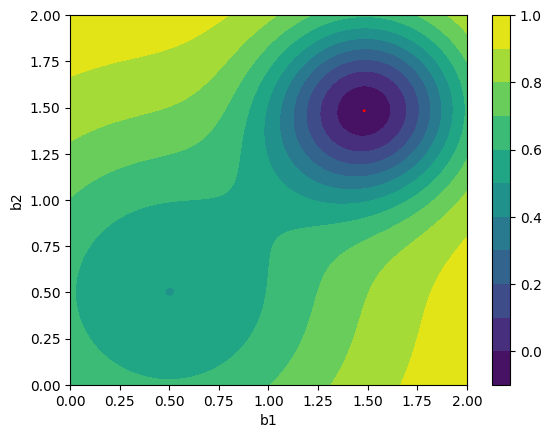

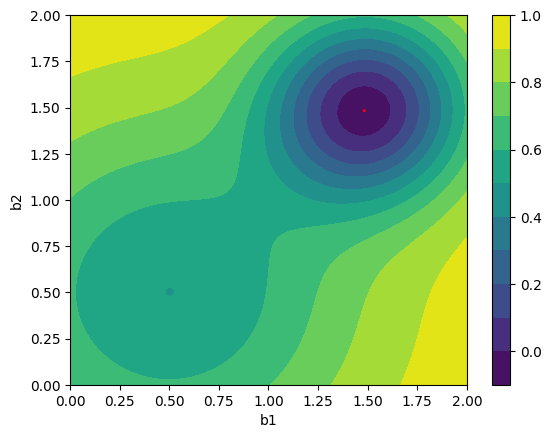

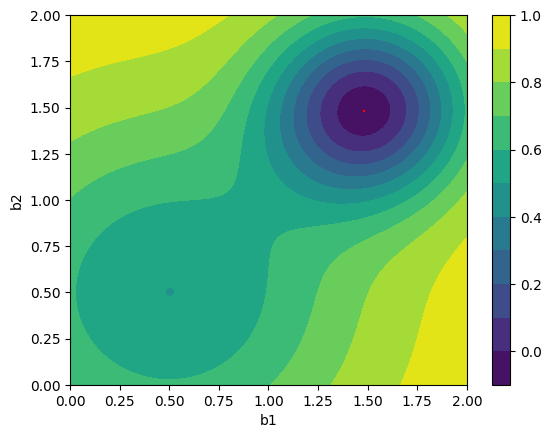

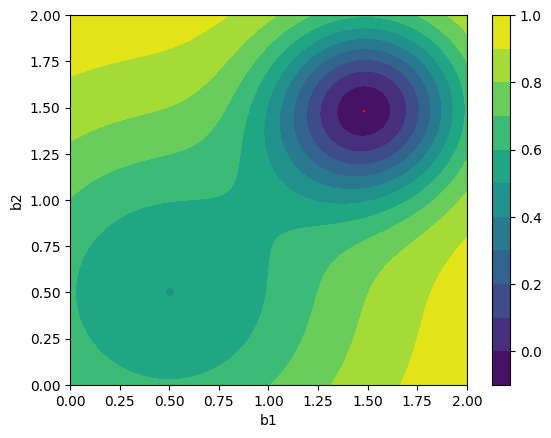

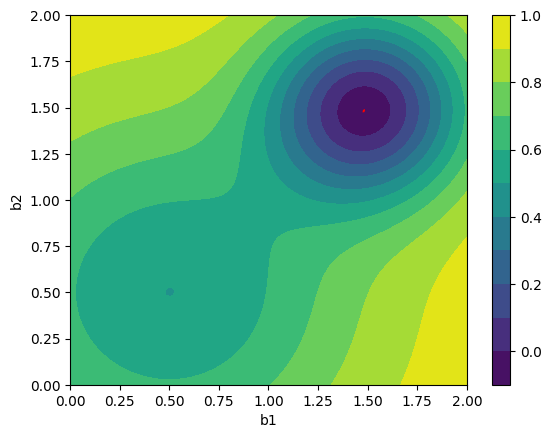

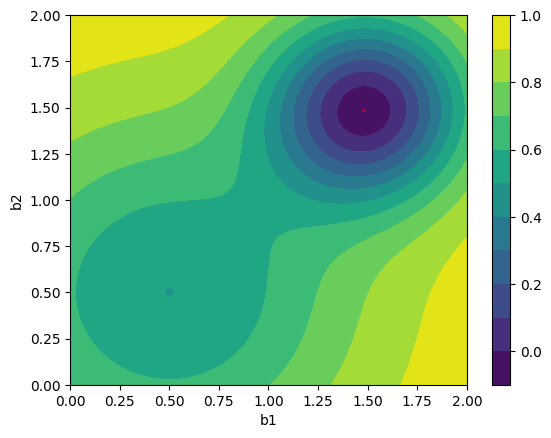

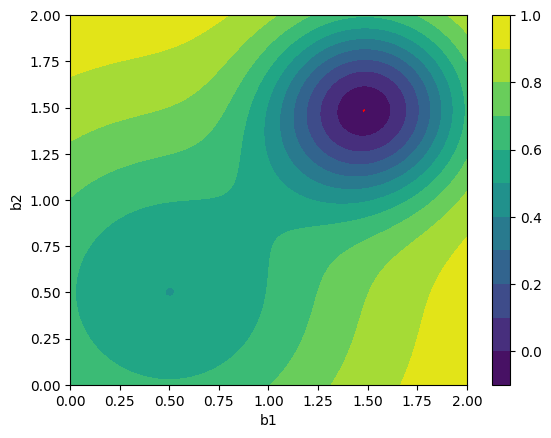

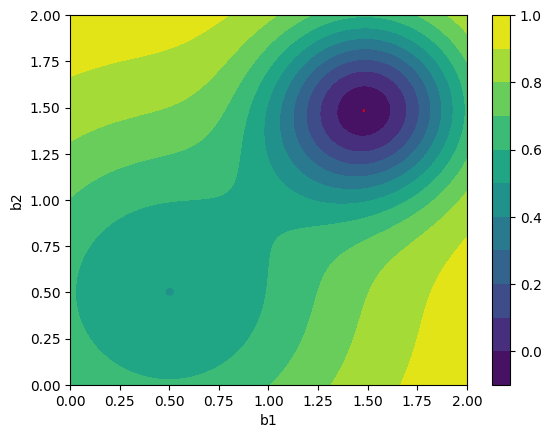

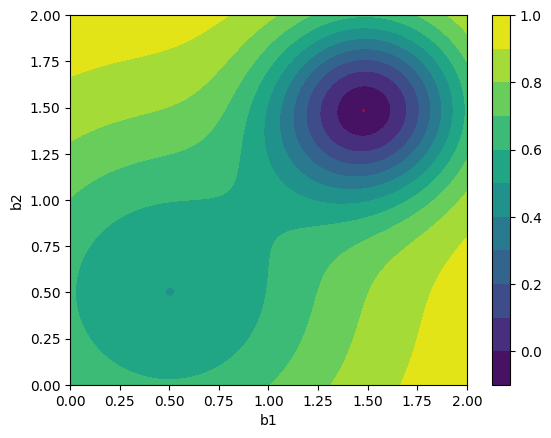

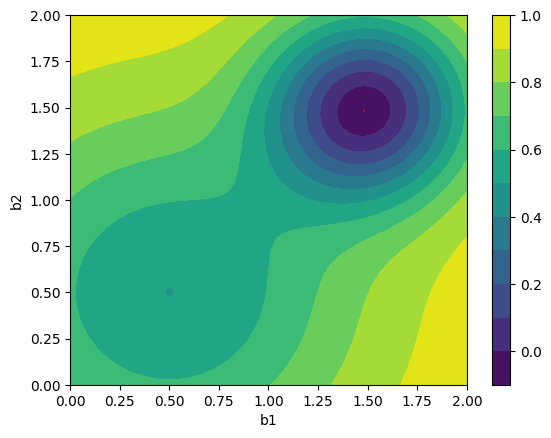

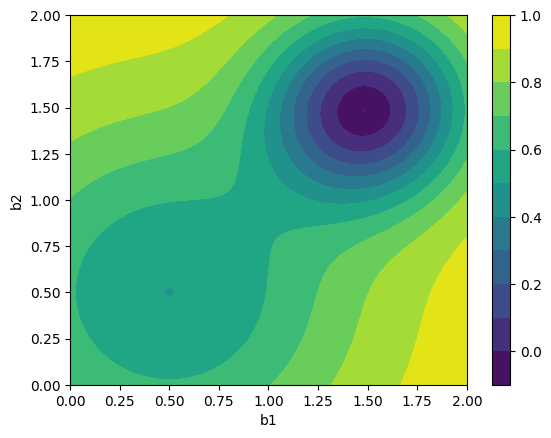

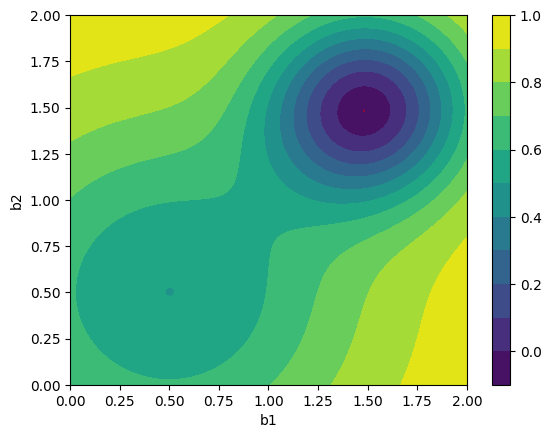

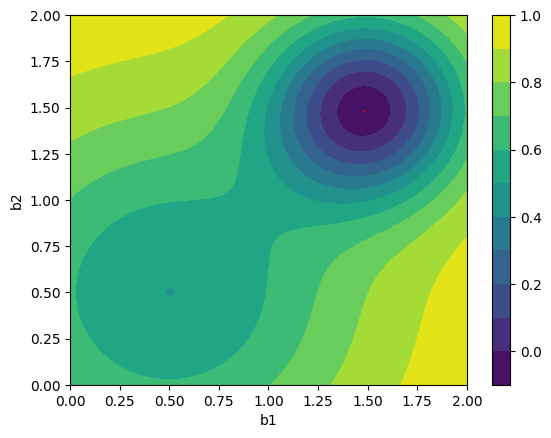

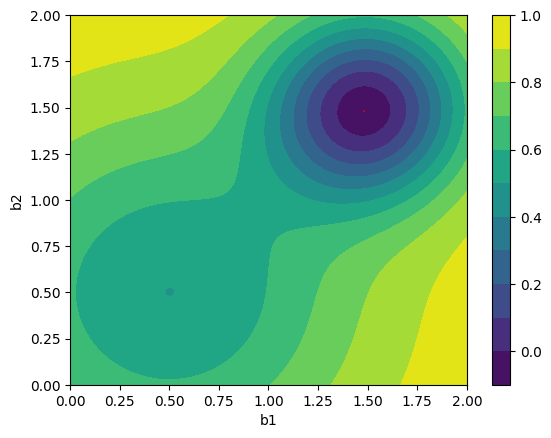

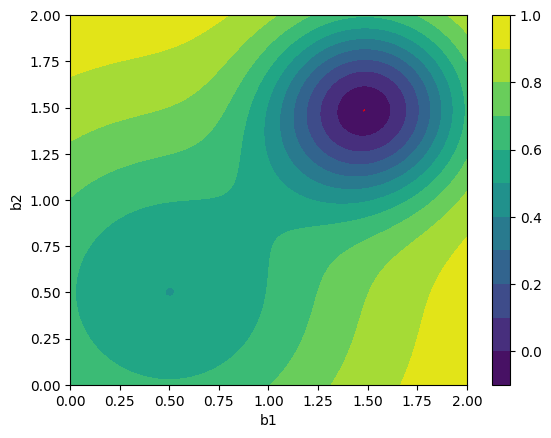

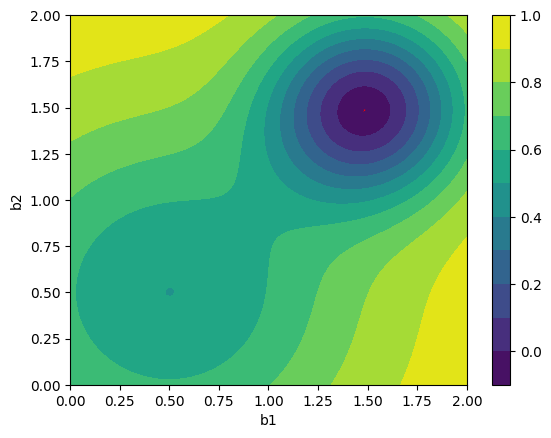

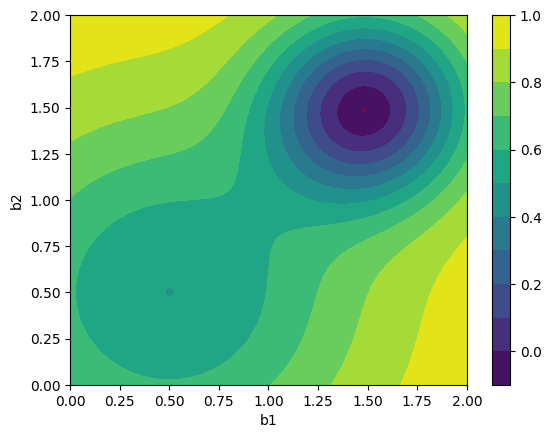

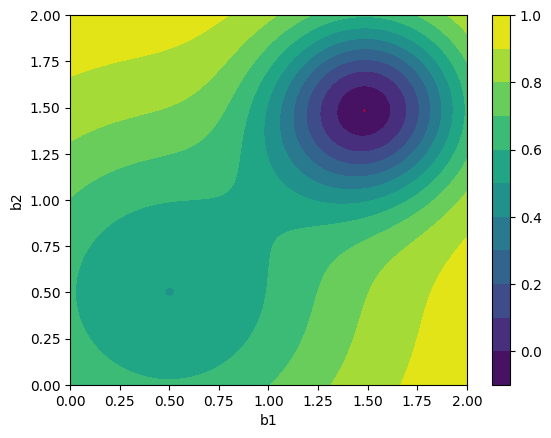

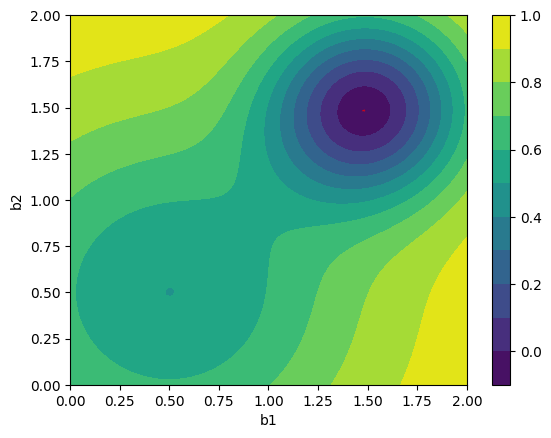

In [192]:
#contour
for i in range(0,50):
    plt.contourf(b1grid, b2grid, J,levels=10)
    hisi = his[i]
    hl0 = []
    for j in range(len(hisi)):
        # plt.scatter(hisi[j][0][0],hisi[j][0][1],color = 'r')
        hl0.append(hisi[j][0])
    hl = np.vstack(hl0)
    poly = plt.Polygon(hl, facecolor="none", edgecolor="r",
                       linewidth=1.5)
    plt.gca().add_patch(poly)
    plt.xlabel('b1')
    plt.ylabel('b2')
    plt.colorbar()
    plt.savefig('fig6/test{}.png'.format(i+1))
    plt.show()

In [193]:
countt = 0
for i in range(0,100):
    l = generate_simplex0()
    N = DownhillSimplex(f, l)
    res = N.run()
    bf = res[0]
    if np.abs((f(bf)-Jmin)/Jmin)<=0.1:
        countt += 1
countt  

39